In [1]:
!pip install geopandas contextily

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point, LineString
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader


In [3]:
# Helper function to convert GPS coordinates to meters
def gps_to_meters(lat_diff, lon_diff, ref_lat):
    lat_meters = lat_diff * 111000  # 1 degree latitude ≈ 111 km
    lon_meters = lon_diff * (111000 * np.cos(np.radians(ref_lat)))  # 1 degree longitude ≈ 111 km * cos(latitude)
    return lat_meters, lon_meters

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load and preprocess data
data = pd.read_csv('/content/drive/MyDrive/Kasungu Telem Pts_June24.csv', parse_dates=['Time.Stamp'])
data = data[["Index", "Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data = data.sort_values(by=['Tag', 'Time.Stamp'])
data['Time_diff'] = data.groupby('Tag')['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data['Latitude'].diff().fillna(0)
data['Lon_diff'] = data['Longitude'].diff().fillna(0)


In [6]:

# Convert GPS differences to meters
data['Lat_meters'], data['Lon_meters'] = gps_to_meters(data['Lat_diff'], data['Lon_diff'], data['Latitude'].mean())


numeric_columns = ['Latitude', 'Longitude']


In [7]:
#Sequence Creation
def create_sequences(data, sequence_length=15, prediction_length=3):
    X, y, tags = [], [], []
    for i in range(sequence_length, len(data) + 1):
        X.append(data.iloc[i-sequence_length:i-prediction_length][['Latitude', 'Longitude']].values)
        y.append(data.iloc[i-prediction_length:i][['Latitude', 'Longitude']].values.flatten())
        tags.append(data.iloc[i-sequence_length]['Tag'])  # Store the Tag
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(tags)

elephants = data['Tag'].unique()
X_list, y_list, tags_list = [], [], []

for elephant in elephants:
    elephant_data = data[data['Tag'] == elephant]
    if len(elephant_data) >= 110:
        X_elephant, y_elephant, tags_elephant = create_sequences(elephant_data)
        if X_elephant.shape[0] > 0:
            X_list.append(X_elephant)
            y_list.append(y_elephant)
            tags_list.append(tags_elephant)

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)
tags = np.concatenate(tags_list, axis=0)


In [8]:
#Train and Test split and dataloader
def train_test_split_by_elephant(X, y, tags, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    test_size = int(len(indices) * test_size)
    train_indices, test_indices = indices[:-test_size], indices[-test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices], tags[train_indices], tags[test_indices]

X_train, X_test, y_train, y_test, tags_train, tags_test = train_test_split_by_elephant(X, y, tags)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [9]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, device='cuda'):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        position = torch.arange(0, max_len, device=device).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * -(np.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)]

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, output_dim, max_seq_length, device):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length, device=device)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, batch_first=True)
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer(src, src)
        output = self.fc_out(output[:, -1, :])
        return output


# Hyperparameters and model initialization
input_dim = 2
d_model = 64
nhead = 4
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 128
output_dim = 6  # 3 points * 2 dimensions
max_seq_length = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, output_dim, max_seq_length, device=device).to(device)


Epoch 1: Train Loss: 2.8652, Validation Loss: 0.0159, Train RMSE: 1.6927, Validation RMSE: 0.1260
Epoch 2: Train Loss: 0.0082, Validation Loss: 0.0051, Train RMSE: 0.0906, Validation RMSE: 0.0716
Epoch 3: Train Loss: 0.0071, Validation Loss: 0.0142, Train RMSE: 0.0843, Validation RMSE: 0.1193
Epoch 4: Train Loss: 0.0064, Validation Loss: 0.0055, Train RMSE: 0.0800, Validation RMSE: 0.0741
Epoch 5: Train Loss: 0.0061, Validation Loss: 0.0073, Train RMSE: 0.0783, Validation RMSE: 0.0855
Epoch 6: Train Loss: 0.0057, Validation Loss: 0.0056, Train RMSE: 0.0754, Validation RMSE: 0.0745
Epoch 7: Train Loss: 0.0054, Validation Loss: 0.0042, Train RMSE: 0.0732, Validation RMSE: 0.0646
Epoch 8: Train Loss: 0.0053, Validation Loss: 0.0039, Train RMSE: 0.0730, Validation RMSE: 0.0624
Epoch 9: Train Loss: 0.0053, Validation Loss: 0.0100, Train RMSE: 0.0726, Validation RMSE: 0.1000
Epoch 10: Train Loss: 0.0050, Validation Loss: 0.0049, Train RMSE: 0.0706, Validation RMSE: 0.0703
Epoch 11: Train Los

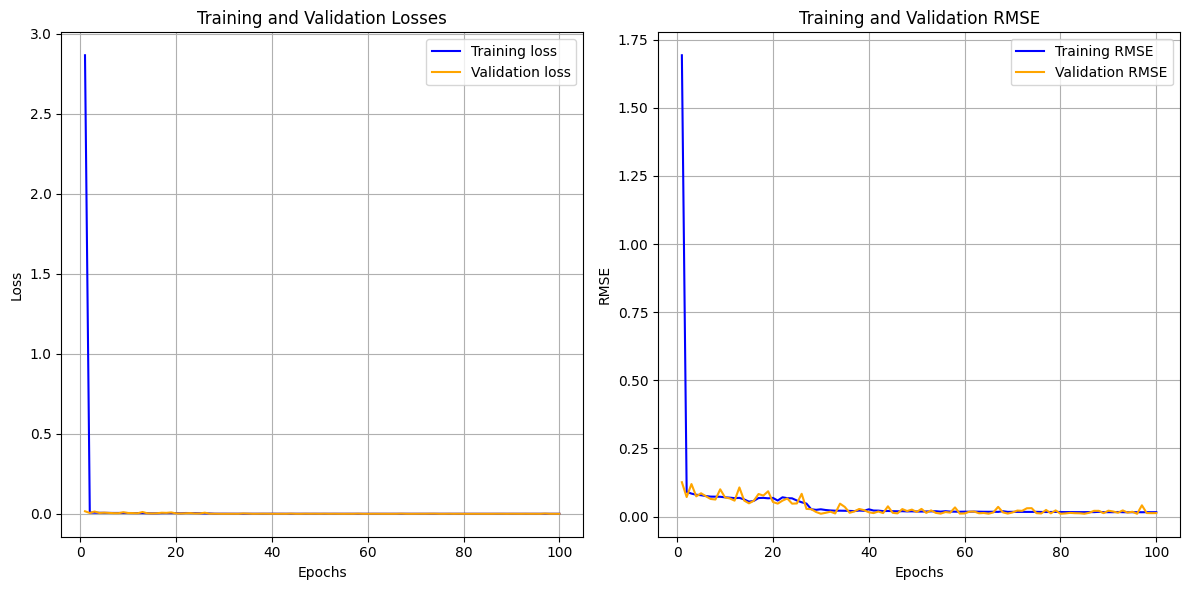

In [10]:

# defining training, validation, and plotting function
def train_validate_and_plot(model, train_loader, val_loader, num_epochs, device):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_rmses = []
    val_rmses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        train_rmse = (avg_train_loss ** 0.5)
        val_rmse = (avg_val_loss ** 0.5)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')
        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = avg_val_loss

    # Plotting the results
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))

    # Plotting losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation loss', color='orange')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plotting RMSE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_rmses, label='Training RMSE', color='blue')
    plt.plot(epochs, val_rmses, label='Validation RMSE', color='orange')
    plt.title('Training and Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#Train and validate the model
train_validate_and_plot(model, train_loader, test_loader, num_epochs=100, device=device)


In [11]:
torch.save(model.state_dict(), 'Transformer.pth')

Average RMSE: 0.011011363


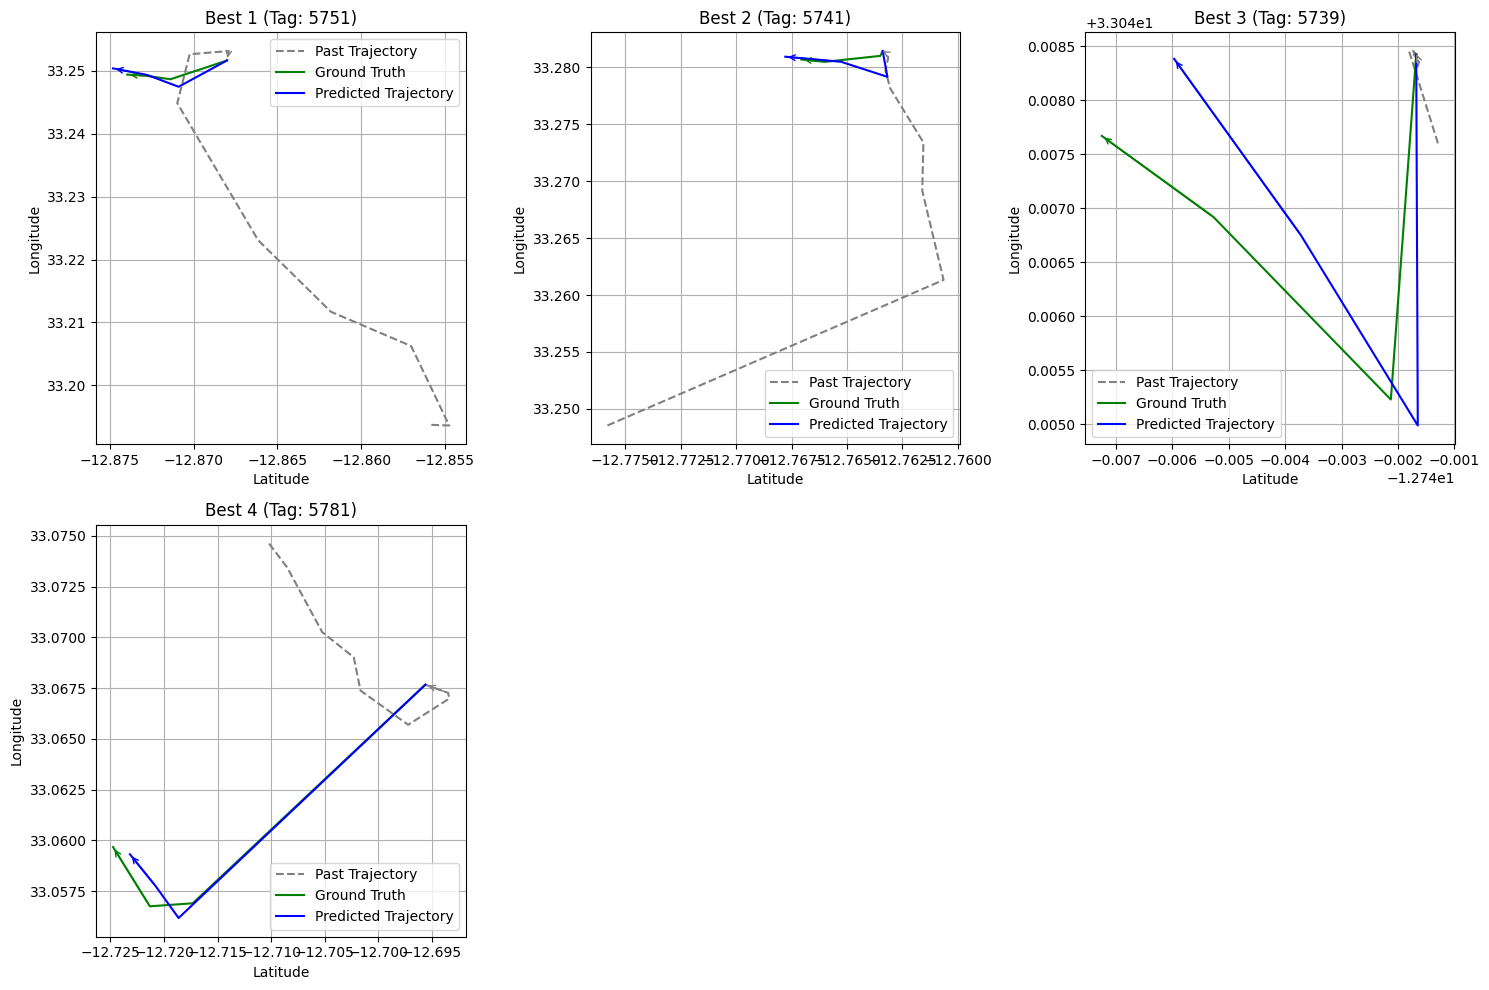

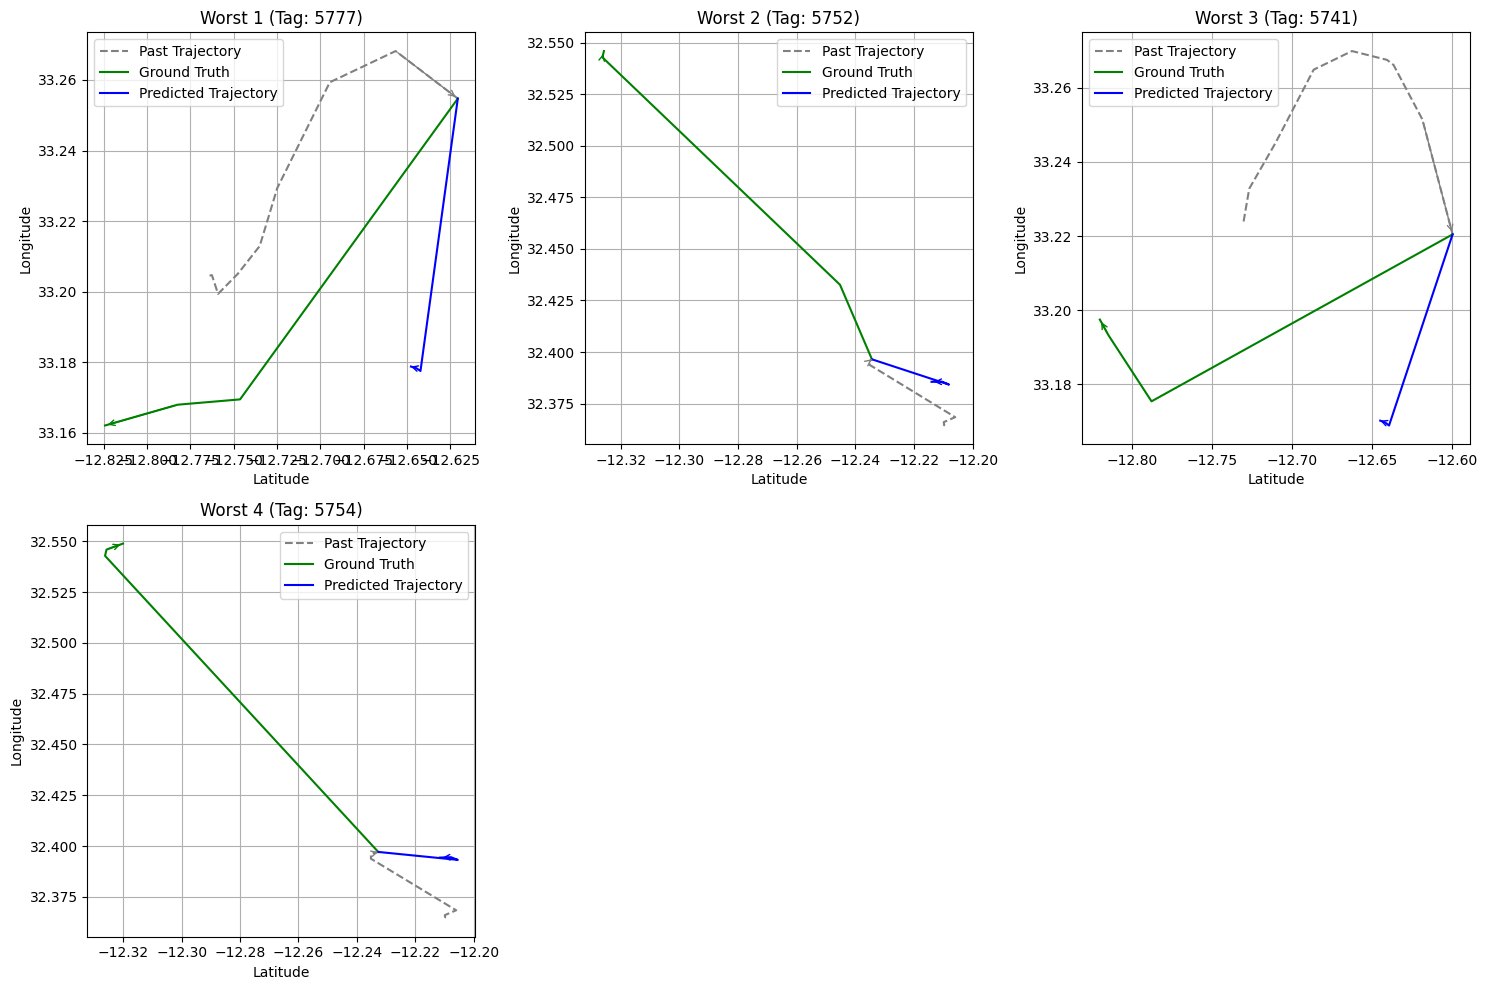

AVerage RMSE in meters: 1017.7306373481475
Mean FDE: 1356.0765743702661
Mean ADE: 1021.4490685150181
Mean Angle Error: 1.365103024200808


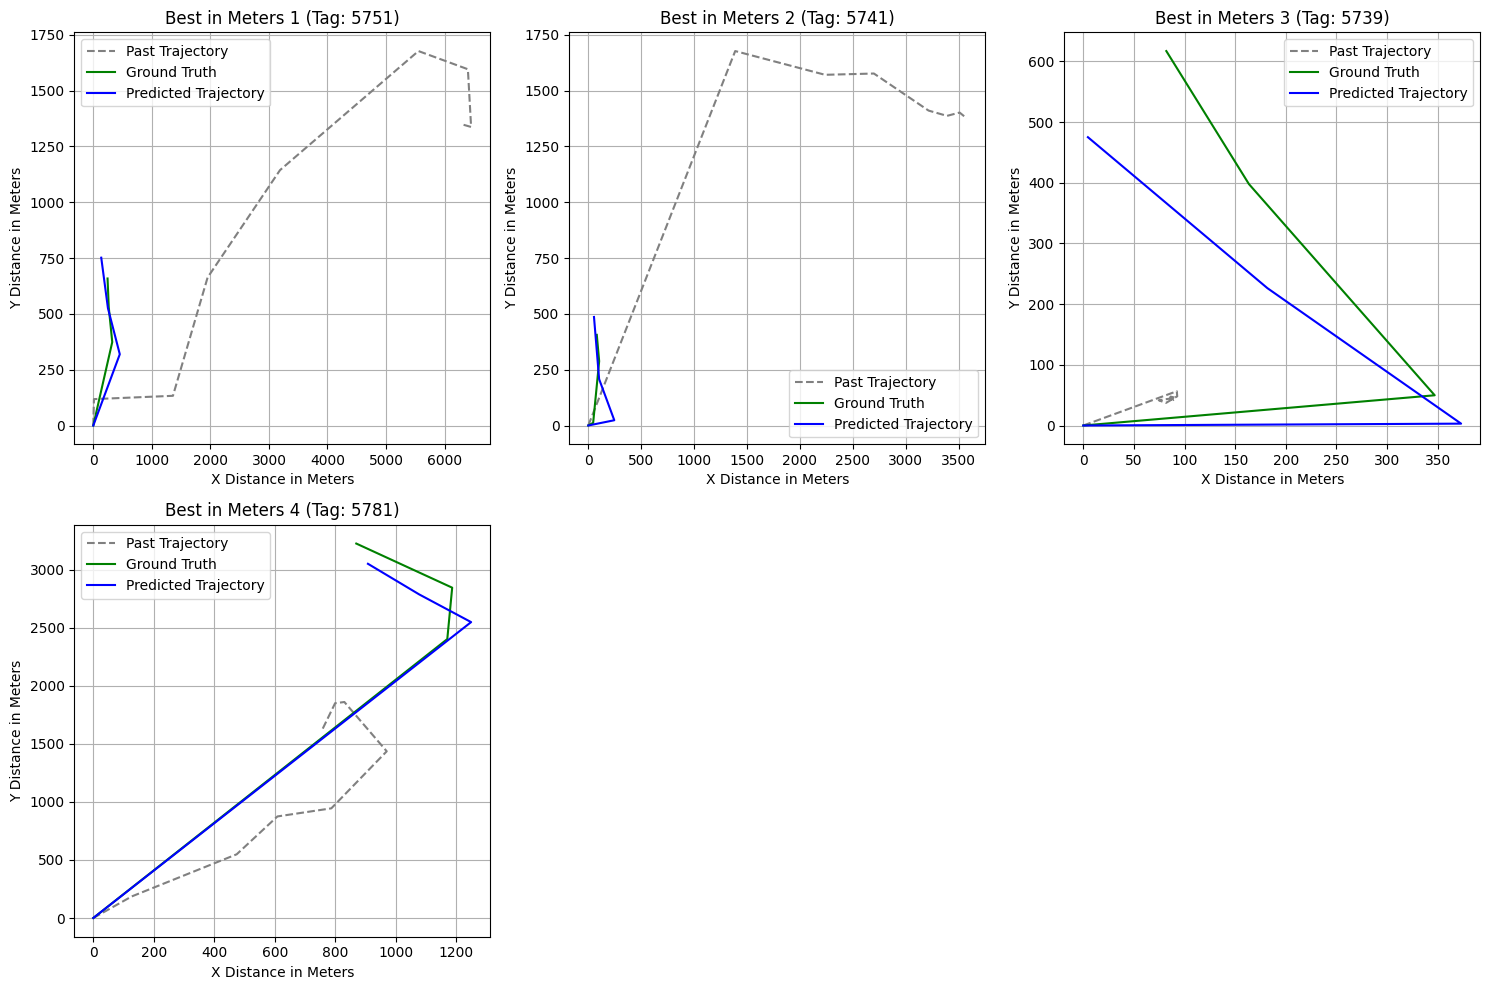

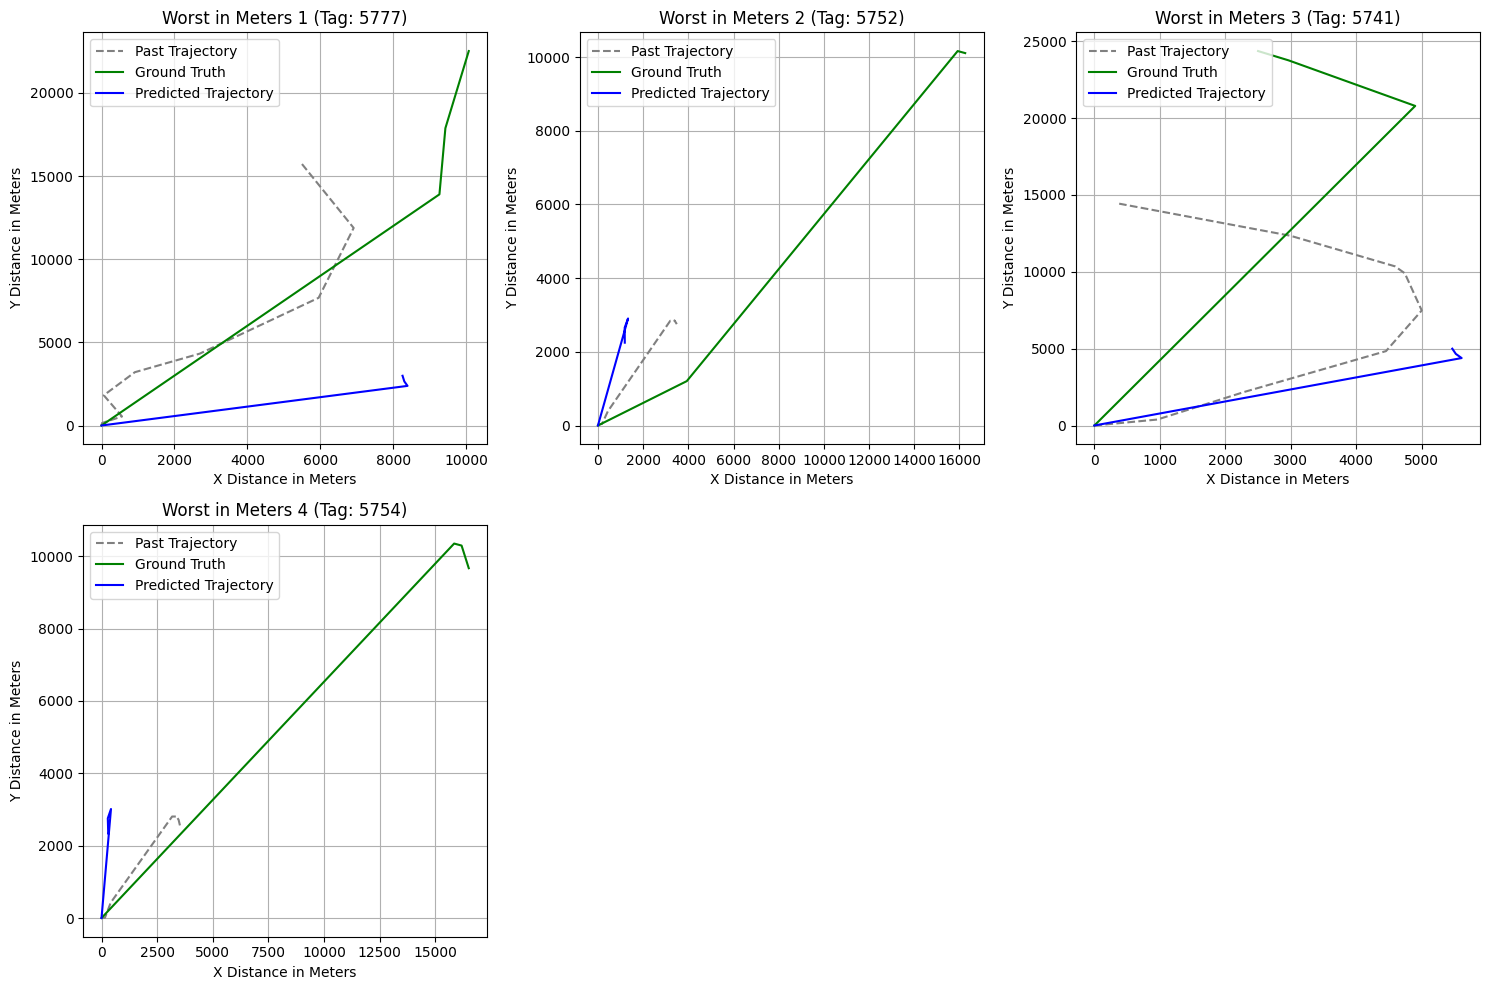

In [12]:

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from geopy.distance import geodesic

def latlon_to_meters(latlon):
    origin = latlon[0]
    x_distances = [geodesic((origin[0], origin[1]), (origin[0], lon)).meters for lon in latlon[:, 1]]
    y_distances = [geodesic((origin[0], origin[1]), (lat, origin[1])).meters for lat in latlon[:, 0]]
    distances = np.column_stack((x_distances, y_distances))
    return distances

def evaluate_model(model, test_loader, tags_test, device, num_examples=4):
    model.load_state_dict(torch.load('Transformer.pth'))  # Load the model
    model.to(device)
    model.eval()

    all_past_data = []
    all_predictions = []
    all_actuals = []
    rmses = []
    tags_list = []

    with torch.no_grad():
        for (X_batch, y_batch), tag in zip(test_loader, tags_test):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predictions = predictions.view(-1, 3, 2).cpu().numpy()
            actuals = y_batch.view(-1, 3, 2).cpu().numpy()
            past_data = X_batch[:, :-3, :2].cpu().numpy()


            for i in range(predictions.shape[0]):
                combined_actuals = np.concatenate([past_data[i][-1:], actuals[i]], axis=0)
                combined_predictions = np.concatenate([past_data[i][-1:], predictions[i]], axis=0)

                all_past_data.append(past_data[i])
                all_predictions.append(combined_predictions)
                all_actuals.append(combined_actuals)
                tags_list.append(tag)

                batch_rmse = np.sqrt(mean_squared_error(predictions[i], actuals[i]))
                rmses.append(batch_rmse)

    average_rmse = np.mean(rmses)

    # Find the 3 best and 3 worst predictions
    sorted_indices = np.argsort(rmses)
    best_indices = sorted_indices[:num_examples]
    worst_indices = sorted_indices[-num_examples:]

    return np.array(all_past_data), np.array(all_actuals), np.array(all_predictions), rmses, average_rmse, best_indices, worst_indices, tags_list

def calculate_additional_metrics(predictions, actuals):
    fdes = []
    ades = []
    angle_errors = []

    all_pred_meters = []
    all_act_meters = []

    for pred, act in zip(predictions, actuals):
        pred_meters = latlon_to_meters(pred)
        act_meters = latlon_to_meters(act)

        all_pred_meters.append(pred_meters)
        all_act_meters.append(act_meters)

        fde = np.linalg.norm(pred_meters[-1] - act_meters[-1])  # Final Displacement Error
        ade = np.mean(np.linalg.norm(pred_meters - act_meters, axis=1))  # Average Displacement Error

        pred_vectors = pred_meters[1:] - pred_meters[:-1]
        act_vectors = act_meters[1:] - act_meters[:-1]
        dot_products = np.einsum('ij,ij->i', pred_vectors, act_vectors)
        norms = np.linalg.norm(pred_vectors, axis=1) * np.linalg.norm(act_vectors, axis=1)

        valid_indices = norms > 0
        cos_angles = np.clip(dot_products[valid_indices] / norms[valid_indices], -1.0, 1.0)
        angles = np.arccos(cos_angles)

        angle_error = np.mean(angles) if angles.size > 0 else 0

        fdes.append(fde)
        ades.append(ade)
        angle_errors.append(angle_error)

    all_pred_meters_flat = np.vstack(all_pred_meters).reshape(-1, 2)
    all_act_meters_flat = np.vstack(all_act_meters).reshape(-1, 2)
    rmse_values = np.sqrt(mean_squared_error(all_pred_meters_flat, all_act_meters_flat))
    average_rmse_meters = np.mean(rmse_values)  # Average RMSE in meters
    mean_fde = np.mean(fdes)  # Mean Final Displacement Error in meters
    mean_ade = np.mean(ades)  # Mean Average Displacement Error in meters
    mean_angle_error = np.mean(angle_errors)  # Mean Angle Error

    return average_rmse_meters, mean_fde, mean_ade, mean_angle_error

def plot_trajectories(past_data, actuals, predictions, indices, tags_list, title='Predictions'):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.plot(past_data[idx][:, 0], past_data[idx][:, 1], 'grey', linestyle ='--', label=f'Past Trajectory ')
        plt.plot(actuals[idx][:, 0], actuals[idx][:, 1], 'g-', label='Ground Truth')
        plt.plot(predictions[idx][:, 0], predictions[idx][:, 1], 'b-', label='Predicted Trajectory')

        # Adding arrows to show the movement
        plt.annotate('', xy=(actuals[idx][-1, 0], actuals[idx][-1, 1]), xytext=(actuals[idx][-2, 0], actuals[idx][-2, 1]), arrowprops=dict(arrowstyle='->', color='green'))
        plt.annotate('', xy=(predictions[idx][-1, 0], predictions[idx][-1, 1]), xytext=(predictions[idx][-2, 0], predictions[idx][-2, 1]), arrowprops=dict(arrowstyle='->', color='blue'))
        plt.annotate('', xy=(past_data[idx][-1, 0], past_data[idx][-1, 1]), xytext=(past_data[idx][-2, 0], past_data[idx][-2, 1]), arrowprops=dict(arrowstyle='->', color='grey'))

        plt.legend(loc='best')
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        plt.title(f'{title} {i + 1} (Tag: {tags_list[idx]})')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_trajectories_meters(past_data, actuals, predictions, indices, tags_list, title='Predictions in Meters'):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        past_meters = latlon_to_meters(past_data[idx])
        actual_meters = latlon_to_meters(actuals[idx])
        predicted_meters = latlon_to_meters(predictions[idx])

        plt.subplot(2, 3, i + 1)
        plt.plot(past_meters[:, 0], past_meters[:, 1], 'grey', linestyle ='--', label=f'Past Trajectory')
        plt.plot(actual_meters[:, 0], actual_meters[:, 1], 'g-', label='Ground Truth')
        plt.plot(predicted_meters[:, 0], predicted_meters[:, 1], 'b-', label='Predicted Trajectory')

        plt.legend(loc='best')
        plt.xlabel('X Distance in Meters')
        plt.ylabel('Y Distance in Meters')
        plt.title(f'{title} {i + 1} (Tag: {tags_list[idx]})')
        plt.grid(True)
    plt.tight_layout()
    plt.show()



# Evaluate the model and plot results
all_past_data, all_actuals, all_predictions, rmses, average_rmse, best_indices, worst_indices, tags_list = evaluate_model(model, test_loader, tags_test, device=device)

print("Average RMSE:", average_rmse)

# Plot the 3 best and 3 worst trajectories with original Lat-Long
plot_trajectories(all_past_data, all_actuals, all_predictions, best_indices, tags_list, title='Best')
plot_trajectories(all_past_data, all_actuals, all_predictions, worst_indices, tags_list, title='Worst')

# Calculate additional metrics and print
average_rmse_meters, mean_fde, mean_ade, mean_angle_error = calculate_additional_metrics(all_predictions, all_actuals)
print(f"AVerage RMSE in meters: {average_rmse_meters}")
print(f"Mean FDE: {mean_fde}")
print(f"Mean ADE: {mean_ade}")
print(f"Mean Angle Error: {mean_angle_error}")

# Plot the 3 best and 3 worst trajectories in meters
plot_trajectories_meters(all_past_data, all_actuals, all_predictions, best_indices, tags_list, title='Best in Meters')
plot_trajectories_meters(all_past_data, all_actuals, all_predictions, worst_indices, tags_list, title='Worst in Meters')


